<a href="https://colab.research.google.com/github/blt2114/SO3_diffusion_example/blob/main/SO3_diffusion_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SO(3) diffusion modeling and the IGSO(3) distribution
The purpose of this notebook is to provide a minimal example of a score-based generative modeling approach on the SO(3) manifold.


Key features include:
* Illustration of the agreement between the IGSO(3) density and the geodesic random walk, and their convergence to the uniform distribution on SO(3).
* Illustration of the agreement between forward and reverse processes that target a discrete measure on SO(3), for which the stein score may be computed directly by automatic differentiation (rather than estimated by score matching)
* An implementation of the isotropic Gaussian on $SO(3)$ (IGSO3) with variance parameter rescaled to agree with the Brownian motion as defined for the canonical inner product on the Lie algebra of $SO(3)$.

This implementation is associated with the following preprint:

This notebook was written by Brian L. Trippe, Valentin de Bortoli, Jason Yim and Emile Mathieu.


In [ ]:
import torch
torch.set_default_dtype(torch.float64)
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

## First define primative operations on the SO(3) manifold

In [ ]:
# Orthonormal basis of SO(3) with shape [3, 3, 3]
basis = torch.tensor([
    [[0.,0.,0.],[0.,0.,-1.],[0.,1.,0.]],
    [[0.,0.,1.],[0.,0.,0.],[-1.,0.,0.]],
    [[0.,-1.,0.],[1.,0.,0.],[0.,0.,0.]]])

# hat map from vector space R^3 to Lie algebra so(3)
def hat(v): return torch.einsum('...i,ijk->...jk', v, basis)

# Logarithmic map from SO(3) to R^3 (i.e. rotation vector)
def Log(R): return torch.tensor(Rotation.from_matrix(R.numpy()).as_rotvec())
    
# logarithmic map from SO(3) to so(3), this is the matrix logarithm
def log(R): return hat(Log(R))

# Exponential map from so(3) to SO(3), this is the matrix exponential
def exp(A): return torch.linalg.matrix_exp(A)

# Exponential map from tangent space at R0 to SO(3)
def expmap(R0, tangent):
    skew_sym = torch.einsum('...ij,...ik->...jk', R0, tangent)
    return torch.einsum('...ij,...jk->...ik', R0, exp(skew_sym))

# Return angle of rotation. SO(3) to R^+
def Omega(R): return torch.arccos((torch.diagonal(R, dim1=-2, dim2=-1).sum(axis=-1)-1)/2)

## Define IGSO3 density, the geodesic random walk and check their agreement.

In [ ]:
# Power series expansion in the IGSO3 density.
def f_igso3(omega, t, L=500):
    ls = torch.arange(L)[None]  # of shape [1, L]
    return ((2*ls + 1) * torch.exp(-ls*(ls+1)*t/2) *
             torch.sin(omega[:, None]*(ls+1/2)) / torch.sin(omega[:, None]/2)).sum(dim=-1)

# IGSO3(Rt; I_3, t), density with respect to the volume form on SO(3) 
def igso3_density(Rt, t, L=500): return f_igso3(Omega(Rt), t, L)

# Marginal density of rotation angle for uniform density on SO(3)
def angle_density_unif(omega):
    return (1-torch.cos(omega))/np.pi

# Normal sample in tangent space at R0
def tangent_gaussian(R0): return torch.einsum('...ij,...jk->...ik', R0, hat(torch.randn(R0.shape[0], 3)))

# Simluation procedure for forward and reverse
def geodesic_random_walk(p_initial, drift, ts):
    Rts = {ts[0]:p_initial()}
    for i in range(1, len(ts)):
        dt = ts[i] - ts[i-1] # negative for reverse process
        Rts[ts[i]] = expmap(Rts[ts[i-1]],
            drift(Rts[ts[i-1]], ts[i-1]) * dt + tangent_gaussian(Rts[ts[i-1]]) * np.sqrt(abs(dt)))
    return Rts

### Simulate the geodesic random walk
N = 5000 # Number of samples
T = 5. # Final time 
ts = np.linspace(0, T, 200) # Discretization of [0, T]

random_walk = geodesic_random_walk(
    p_initial=lambda: exp(torch.zeros(N, 3, 3)), drift=lambda Rt, t: 0., ts=ts)

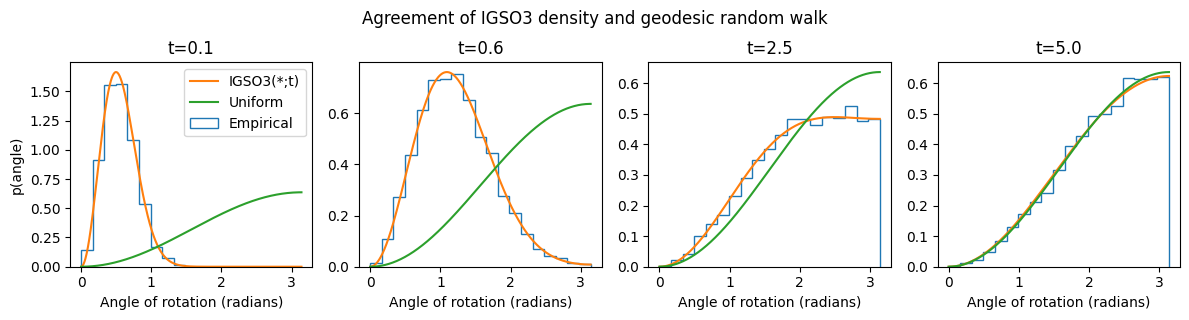

In [ ]:
t_idcs_plot = [5, 25, 100, -1]
_, axs = plt.subplots(1, len(t_idcs_plot), dpi=100, figsize=(3*len(t_idcs_plot), 3))
for i, t_idx in enumerate(t_idcs_plot):
  # Plot empirical distribution of angle of rotation from geodesic random walk
  bins = np.linspace(0, np.pi, 20)
  axs[i].hist(Omega(random_walk[ts[t_idx]]), bins=bins, density=True, histtype='step', label='Empirical')
  axs[i].set_title(f"t={ts[t_idx]:0.01f}")

  
  # Compute density on angle of rotation, and the density for the uniform distribution
  omega_grid = torch.linspace(0, np.pi, 1000)
  pdf_angle = f_igso3(omega_grid, ts[t_idx])*angle_density_unif(omega_grid)
  axs[i].plot(omega_grid, pdf_angle.numpy(), label="IGSO3(*;I, t)")
  axs[i].plot(omega_grid, angle_density_unif(omega_grid).numpy(), label="Uniform")

  axs[i].set_xlabel("Angle of rotation (radians)")
axs[0].legend()
axs[0].set_ylabel("p(angle)")

plt.suptitle("Agreement of IGSO3 density and geodesic random walk", y=1.05)
plt.tight_layout()
plt.show()

Notice that the geodesic random walk and IGSO(3) density closely agree, and that by `t=5.0`, both have nearly converged to the uniform distribution on SO(3).

# Define toy target, intermediate and invariant densities:
* Target $p_0(\cdot)=N_{\mathrm{atoms}}^{-1}\sum_{n=1}^{N_{\mathrm{atoms}}} \delta_{R_n}(\cdot),$ where each $\delta_R$ is as Dirac mass on an arbitrary, fixed rotation $R_n.$
* Invariant $p_{\mathrm{inv}}(\cdot)=\mathcal{U}_{SO(3)}(\cdot)$
* Intermediate $p_t(\cdot) = N_{\mathrm{atoms}}^{-1} \sum_{n=1}^{N_{\mathrm{atoms}}} p_{t|0}(\cdot | R_n)$  score of the noised distribution for each `t`, and the geodesic random walk for sampling for the forward and reverse processes.

And additionally define the score, $\nabla_R \log p_t(R)$ for each $t$ and $R$ using automatic differentiation.

In [ ]:
# Sample N times from U(SO(3)) by inverting CDF of uniform distribution of angle 
def p_inv(N, M=1000):
    omega_grid = torch.linspace(0, np.pi, M)
    cdf = np.cumsum(angle_density_unif(omega_grid).numpy())/(M/np.pi)
    omegas = np.interp(np.random.rand(N), cdf, omega_grid)
    axes = np.random.randn(N, 3)
    axes = omegas[:, None]* axes/np.linalg.norm(axes, axis=-1, keepdims=True)
    return exp(hat(torch.tensor(axes)))

## Define discrete target measure on SO(3), and it's score for t>0
N_atoms = 3
mu_ks = p_inv(N_atoms) # Atoms defining target measure

# Sample p_0 ~ (1/N_atoms)\sum_k Dirac_{mu_k}
def p_0(N): return mu_ks[torch.randint(mu_ks.shape[0], size=[N])] 

# Density of discrete target noised for time t
def p_t(Rt, t): return sum([
        igso3_density(torch.einsum('ji,...jk->...ik', mu_k, Rt), t)
        for mu_k in mu_ks])/N_atoms

# Riemannian gradient of f at R using automatic differentiation
def riemannian_gradient(f, R):
    coefficients = torch.zeros(list(R.shape[:-2])+[3], requires_grad=True)
    R_delta = expmap(R, torch.einsum('...ij,...jk->...ik', R, hat(coefficients)))
    grad_coefficients = torch.autograd.grad(f(R_delta).sum(), coefficients)[0]
    return torch.einsum('...ij,...jk->...ik', R, hat(grad_coefficients))

# Stein score of p_t
def score_t(Rt, t): return riemannian_gradient(lambda R_: torch.log(p_t(R_, t)), Rt)

# Simulate the forward and reverse processes 

In [ ]:
forward_samples = geodesic_random_walk(
    p_initial=lambda: p_0(N), drift=lambda Rt, t: 0., ts=ts)
reverse_samples = geodesic_random_walk(
    p_initial=lambda: p_inv(N), drift=lambda Rt, t: -score_t(Rt, t), ts=ts[::-1])

# Visualize the agreement of the marginals of the forward and reverse processes at several time steps

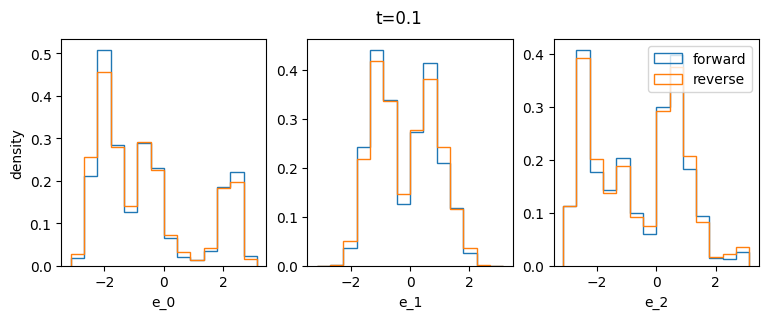

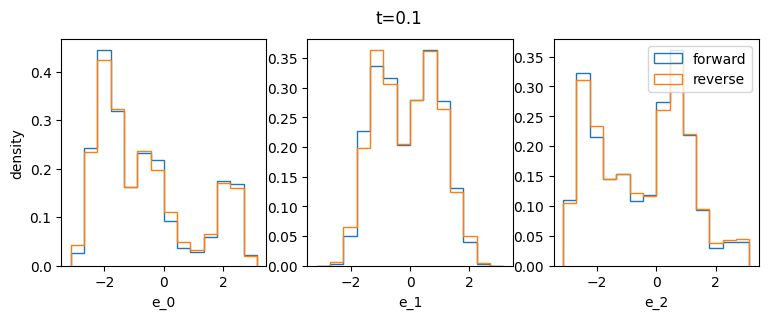

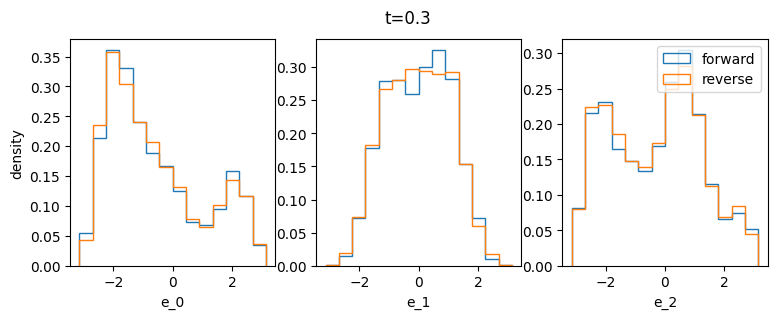

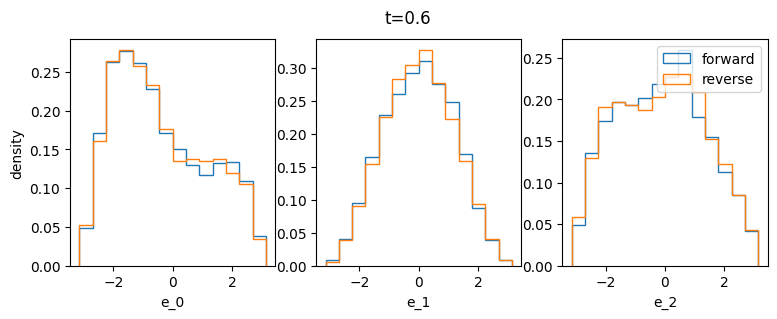

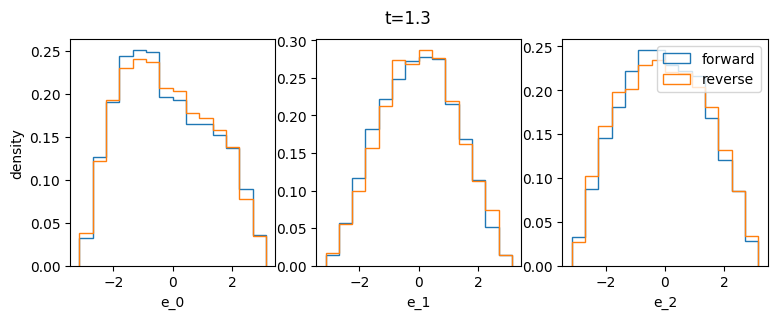

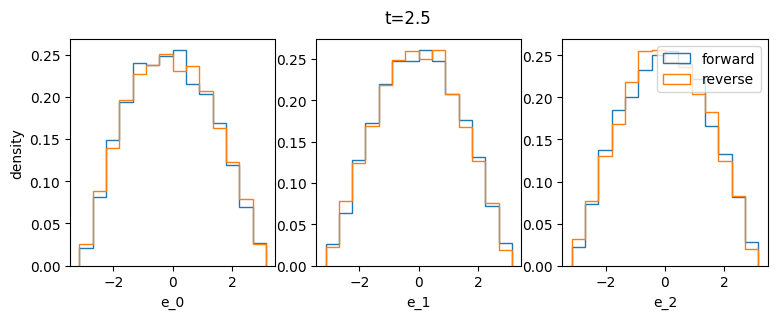

In [ ]:
# Plot comparison of forward and reverse process in orthormal basis of so(3)
for i in [3, 5, 10, 25, 50, 100]:
    t = ts[i]
    Rt_forward = Log(forward_samples[ts[i]])
    Rt_reverse = Log(reverse_samples[ts[i]])
    fig, axs = plt.subplots(1, 3, dpi=100, figsize=(9, 3))
    fig.suptitle(f't={t:.1f}')
    bins = np.linspace(-np.pi, np.pi, 15)
    for Rt, label in [(Rt_forward, "forward"), (Rt_reverse, "reverse")]:
        axs[0].set_ylabel("density")
        for i in range(3):
            axs[i].hist(Rt[:, i].numpy(), bins, density=True, histtype='step', label=label)
            axs[i].set_xlabel(f"e_{i}")
    plt.legend()